In [2]:
import ffmpeg
import os

video_path = 'C:/Users/srira/Downloads/fifa1.mp4'

def check_ffmpeg_installed():
    try:
        result = os.system('ffmpeg -version')
        if result != 0:
            raise EnvironmentError("ffmpeg is not installed or not found in PATH.")
    except Exception as e:
        print(e)
        return False
    return True

if check_ffmpeg_installed():
    try:
        probe = ffmpeg.probe(video_path)
        video_info = next(stream for stream in probe['streams'] if stream['codec_type'] == 'video')

        print("Frame Information:")
        print(f"Duration: {video_info['duration']} seconds")
        print(f"Number of Frames: {video_info['nb_frames']}")
        print(f"Codec: {video_info['codec_name']}")
        print(f"Width: {video_info['width']}")
        print(f"Height: {video_info['height']}")
    except ffmpeg.Error as e:
        print("An error occurred while probing the video:", e)
else:
    print("Please install ffmpeg and add it to PATH.")


Frame Information:
Duration: 29.214933 seconds
Number of Frames: 1454
Codec: h264
Width: 848
Height: 478


In [3]:
import ffmpeg
import json
import subprocess

video_path = 'C:/Users/srira/Downloads/fifa1.mp4'

try:
    command = [
        'ffprobe',
        '-v', 'error',
        '-select_streams', 'v:0',
        '-show_entries', 'frame=pict_type',
        '-of', 'json',
        video_path
    ]
    result = subprocess.run(command, capture_output=True, text=True, check=True)
    frames = json.loads(result.stdout)['frames']

    frame_counts = {'I': 0, 'P': 0, 'B': 0}

    for frame in frames:
        if 'pict_type' in frame:
            frame_counts[frame['pict_type']] += 1

    total_frames = sum(frame_counts.values())
    frame_percentages = {key: (value / total_frames) * 100 for key, value in frame_counts.items()}

    print("Frame Counts:", frame_counts)
    print("Frame Percentages:", frame_percentages)
except subprocess.CalledProcessError as e:
    print("An error occurred while extracting frame details:", e.stderr)
except Exception as e:
    print("An unexpected error occurred:", str(e))


 



Frame Counts: {'I': 5, 'P': 1449, 'B': 0}
Frame Percentages: {'I': 0.34387895460797796, 'P': 99.65612104539203, 'B': 0.0}


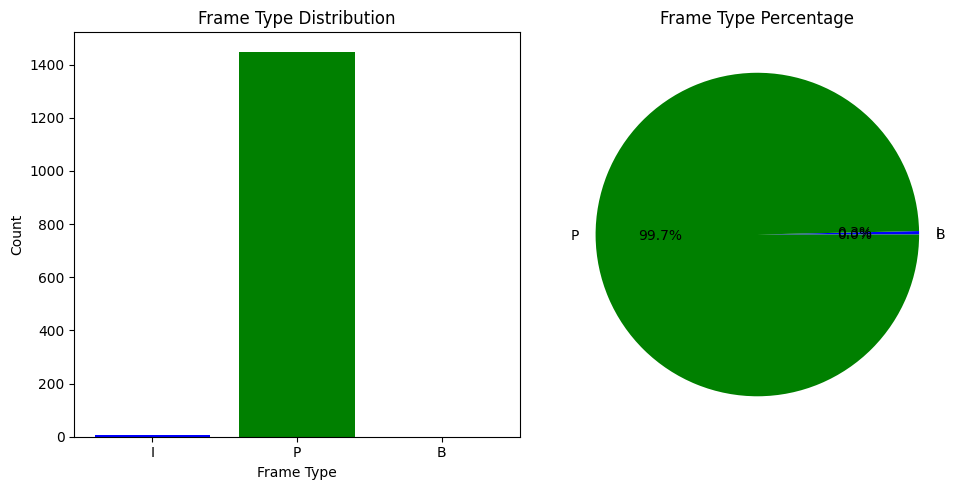

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(frame_counts.keys(), frame_counts.values(), color=['blue', 'green', 'red'])
plt.title('Frame Type Distribution')
plt.xlabel('Frame Type')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.pie(frame_percentages.values(), labels=frame_percentages.keys(), autopct='%1.1f%%', colors=['blue', 'green', 'red'])
plt.title('Frame Type Percentage')

plt.tight_layout()
plt.show()


In [5]:
import os
import ffmpeg

video_path = 'C:/Users/srira/Downloads/fifa1.mp4'

output_dir = 'extracted_frames'

os.makedirs(output_dir, exist_ok=True)

try:

    ffmpeg.input(video_path).output(f'{output_dir}/frame_%04d_I.png', vf=r'select=eq(pict_type\,I)').run()
   
    ffmpeg.input(video_path).output(f'{output_dir}/frame_%04d_P.png', vf=r'select=eq(pict_type\,P)').run()
 
    ffmpeg.input(video_path).output(f'{output_dir}/frame_%04d_B.png', vf=r'select=eq(pict_type\,B)').run()
except ffmpeg.Error as e:
    print("An error occurred while extracting frames:", e.stderr.decode('utf-8'))



In [6]:
from PIL import Image
import glob

def display_frames(frame_type):
    frame_files = glob.glob(f'{output_dir}/frame_*_{frame_type}.png')
    for frame_file in frame_files[:5]:  
        img = Image.open(frame_file)
        img.show()

display_frames('I')
display_frames('P')
display_frames('B')


In [7]:
import os

def calculate_frame_sizes(frame_type):
    frame_files = glob.glob(f'{output_dir}/frame_*_{frame_type}.png')
    sizes = [os.path.getsize(frame_file) for frame_file in frame_files]
    return sizes

i_frame_sizes = calculate_frame_sizes('I')
p_frame_sizes = calculate_frame_sizes('P')
b_frame_sizes = calculate_frame_sizes('B')

average_sizes = {
    'I': sum(i_frame_sizes) / len(i_frame_sizes) if i_frame_sizes else 0,
    'P': sum(p_frame_sizes) / len(p_frame_sizes) if p_frame_sizes else 0,
    'B': sum(b_frame_sizes) / len(b_frame_sizes) if b_frame_sizes else 0
}

print("Average Frame Sizes (in bytes):", average_sizes)


Average Frame Sizes (in bytes): {'I': 441338.2646276596, 'P': 542976.0869863014, 'B': 0}


In [8]:
compression_efficiency = {
    'I': 'I frames are key frames and contain the complete image data. They are larger in size but crucial for reference.',
    'P': 'P frames contain differences from the previous frames and are usually smaller in size. They depend on I or P frames for reconstruction.',
    'B': 'B frames contain differences from both previous and following frames, making them the most compressed and smallest in size.'
}

print("Compression Efficiency of Frame Types:")
for frame_type, description in compression_efficiency.items():
    print(f"{frame_type} frames: {description}")


Compression Efficiency of Frame Types:
I frames: I frames are key frames and contain the complete image data. They are larger in size but crucial for reference.
P frames: P frames contain differences from the previous frames and are usually smaller in size. They depend on I or P frames for reconstruction.
B frames: B frames contain differences from both previous and following frames, making them the most compressed and smallest in size.


In [9]:
import os
import ffmpeg

video_path = 'C:/Users/srira/Downloads/fifa1.mp4'

i_frames_dir = 'C:/Users/srira/Desktop/i_frames'


os.makedirs(i_frames_dir, exist_ok=True)

try:
    
    ffmpeg.input(video_path).output(f'{i_frames_dir}/frame_%04d_I.png', vf=r'select=eq(pict_type\,I)').run()
except ffmpeg.Error as e:
    print("An error occurred while extracting I frames:", e.stderr.decode('utf-8'))



In [10]:
output_video_path = 'C:/Users/srira/Desktop/reconstructed_video.mp4'

try:
    ffmpeg.input(f'{i_frames_dir}/frame_%04d_I.png', framerate=1).output(output_video_path, vcodec='libx264', pix_fmt='yuv420p').run()
    print(f"Reconstructed video saved at {output_video_path}")
except ffmpeg.Error as e:
    print("An error occurred while reconstructing the video:", e.stderr.decode('utf-8'))


Reconstructed video saved at C:/Users/srira/Desktop/reconstructed_video.mp4
